In [85]:
%pip install nbformat
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [86]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [87]:
%run ml_project_normalized.ipynb

Note: you may need to restart the kernel to use updated packages.
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
dropped columns


C:\Users\casey\AppData\Local\Temp\ipykernel_2304\1199118304.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

import numpy as np
import pandas as pd

def train_classifier(X_train, y_train, X_test, rare_classes, cat_cols):
    """
    Trains an XGBoost model using hyperparameter tuning.
    Only the categorical columns in cat_cols will be one-hot encoded.
    
    Parameters:
    X_train (pd.DataFrame): Training features.
    y_train (pd.Series or np.array): Training target values.
    X_test (pd.DataFrame): Test features.
    rare_classes (list): List of integer-encoded classes to be oversampled.
    cat_cols (set or list): Column names of categorical features to be one-hot encoded.
    
    Returns:
        best_estimator: The best estimator from RandomizedSearchCV.
        test_predictions: The predicted labels for X_test from the best estimator.
        df_importances: A DataFrame with features and their importance scores.
    """
    
    # Calculate sample weights.
    class_labels = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
    class_weight_dict = dict(zip(class_labels, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])
    
    # Determine categorical columns present in X_train.
    categorical_features = [col for col in X_train.columns if col in cat_cols]
    
    # Ensure all categorical columns are uniformly typed (convert to string)
    for col in categorical_features:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(str)
        if col in X_test.columns:
            X_test[col] = X_test[col].astype(str)
    
    # Create a ColumnTransformer for one-hot encoding.
    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
        ],
        remainder='passthrough'
    )
    
    # Define the pipeline.
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("xgb", XGBClassifier(eval_metric='logloss', verbosity=1))
    ])
    
    # Define hyperparameter distributions for RandomizedSearchCV.
    param_distributions = {
        "xgb__max_depth": randint(2, 11),
        "xgb__learning_rate": uniform(0.01, 0.29),
        "xgb__n_estimators": randint(50, 501),
        "xgb__subsample": uniform(0.3, 0.7),
        "xgb__colsample_bytree": uniform(0.3, 0.7),
        "xgb__min_child_weight": randint(1, 8),
        "xgb__gamma": uniform(0, 1.0),
        "xgb__reg_alpha": uniform(0, 1.0),
        "xgb__reg_lambda": uniform(0.5, 2.5)
    }
    
    # Set up stratified cross-validation.
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=1000,  # Adjust the number of iterations as needed.
        cv=stratified_cv,
        scoring='balanced_accuracy',
        verbose=3,
        random_state=42,
    )
    
    print(f"\n[INFO] Starting training with {len(X_train)} samples and {len(y_train)} labels")
    
    # Fit the model with hyperparameter search.
    randomized_search.fit(X_train, y_train, **{'xgb__sample_weight': sample_weights})
    print(f"[INFO] Training complete. Best model fitted on {len(X_train)} samples.\n")
    
    # Display one-hot encoded features for inspection.
    best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
    encoded_X_train = best_preprocessor.transform(X_train)
    if hasattr(encoded_X_train, "toarray"):
        encoded_X_train = encoded_X_train.toarray()
    feature_names = best_preprocessor.get_feature_names_out()
    X_train_encoded_df = pd.DataFrame(encoded_X_train, columns=feature_names)
    print("Sample of transformed training features:")
    print(X_train_encoded_df.head())
    
    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation accuracy:', randomized_search.best_score_)
    
    cv_scores = cross_val_score(
        randomized_search.best_estimator_,
        X_train,
        y_train,
        cv=5,
        verbose=3,
        scoring='balanced_accuracy'
    )
    print('Generalization accuracy (via cross_val_score):', cv_scores.mean())
    
    # Predict on test data using the best estimator.
    test_predictions = randomized_search.predict(X_test)
    
    # Extract feature importances from the trained model.
    best_estimator = randomized_search.best_estimator_
    best_preprocessor = best_estimator.named_steps['preprocessor']
    feature_names = best_preprocessor.get_feature_names_out()
    xgb_model = best_estimator.named_steps['xgb']
    importances = xgb_model.feature_importances_
    
    # Create a DataFrame with feature names and importance scores.
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    return best_estimator, test_predictions, df_importances


In [89]:
# from sklearn.utils import resample
# df_train_downsample = resample(df_train, replace=True, n_samples=10000, random_state=42)
# print(df_train_downsample.shape)
X_train = df_train.copy()
print(X_train['breed'].unique())
X_train = bucket_seasons(X_train)
X_train = bucket_days(X_train)
X_train = X_train.drop(columns=['intake_month', 'intake_hour'])
label_column = X_train.pop('outcome_type')
X_train.insert(X_train.shape[1], 'outcome_type', label_column)   


[2 7 'Common' 3 0 5 4 'Rare' 8 1 'Unknown' 6]


In [90]:
X_test = df_test.copy()
X_test = bucket_seasons(X_test)
X_test = bucket_days(X_test)
X_test = X_test.drop(columns=['intake_month', 'intake_hour'])
X_test.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,primary_color,is_mix,season,time_of_day
0,Stray,Normal / Behavior,Dog,Neutered Male,24.0,7,2019,tricolor,1,Winter,Afternoon
1,Stray,Sick,Cat,Intact Female,1.0,Common,2013,calico,1,Fall,Morning
2,Stray,Normal / Behavior,Dog,Neutered Male,48.0,3,2014,cream,1,Summer,Morning
3,Stray,Normal / Behavior,Dog,Intact Female,5.0,4,2015,brown,0,Summer,Evening
4,Stray,Injured,Cat,Intact Female,24.0,Common,2017,black,1,Winter,Morning


In [91]:
# Encode the target variable.
le = LabelEncoder()
y_train = X_train['outcome_type']
X_train = X_train.drop(columns=['outcome_type'])
y_train = le.fit_transform(y_train)
print('Encoding mapping:', le.classes_)

# Identify rare classes that need oversampling.
rare_classes = [
    label for label, count in pd.Series(y_train).value_counts().items()
    if count < 0.05 * len(y_train)
]
print("Rare classes:")
for cls in rare_classes:
    print(f"  {cls}: {le.classes_[cls]}")

# Define column groups (this example will one-hot encode all columns, so cat_cols and num_cols are not used in the transformer).
cat_cols = {'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'intake_month', 'intake_hour', 'intake_year', 'season', 'time_of_day'}
categorical_features = [col for col in X_train.columns if col in cat_cols]

cat_cols_freq = ['primary_color']

# Frequency encode selected high-cardinality features
for col in cat_cols_freq:
  freq_map = X_train[col].value_counts()
  X_train[col] = X_train[col].map(freq_map)
  X_test[col]  = X_test[col].map(freq_map).fillna(0)

# Train the classifier with the refactored pipeline.
best_model, test_predictions, df_importances = train_classifier(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    rare_classes=rare_classes,
    cat_cols=categorical_features
)

# Convert predictions back to original labels.
predictions = le.inverse_transform(test_predictions)

# Save predictions; assumes save_predictions is defined elsewhere.
save_predictions(predictions, 'xg_boost')

Encoding mapping: ['Adoption' 'Died' 'Euthanasia' 'Return to Owner' 'Transfer']
Rare classes:
  2: Euthanasia
  1: Died

[INFO] Starting training with 111155 samples and 111155 labels
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.22227824312530747, xgb__max_depth=6, xgb__min_child_weight=7, xgb__n_estimators=171, xgb__reg_alpha=0.15599452033620265, xgb__reg_lambda=0.6452090304204987, xgb__subsample=0.9063233020424546;, score=0.536 total time=   1.1s
[CV 2/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.22227824312530747, xgb__max_depth=6, xgb__min_child_weight=7, xgb__n_estimators=171, xgb__reg_alpha=0.15599452033620265, xgb__reg_lambda=0.6452090304204987, xgb__subsample=0.9063233020424546;, score=0.510 total time=   1.1s
[CV 3/5] END xgb__colsample_bytree=0.5621780831931538, xgb__gamma=0.9507143064099162, xgb

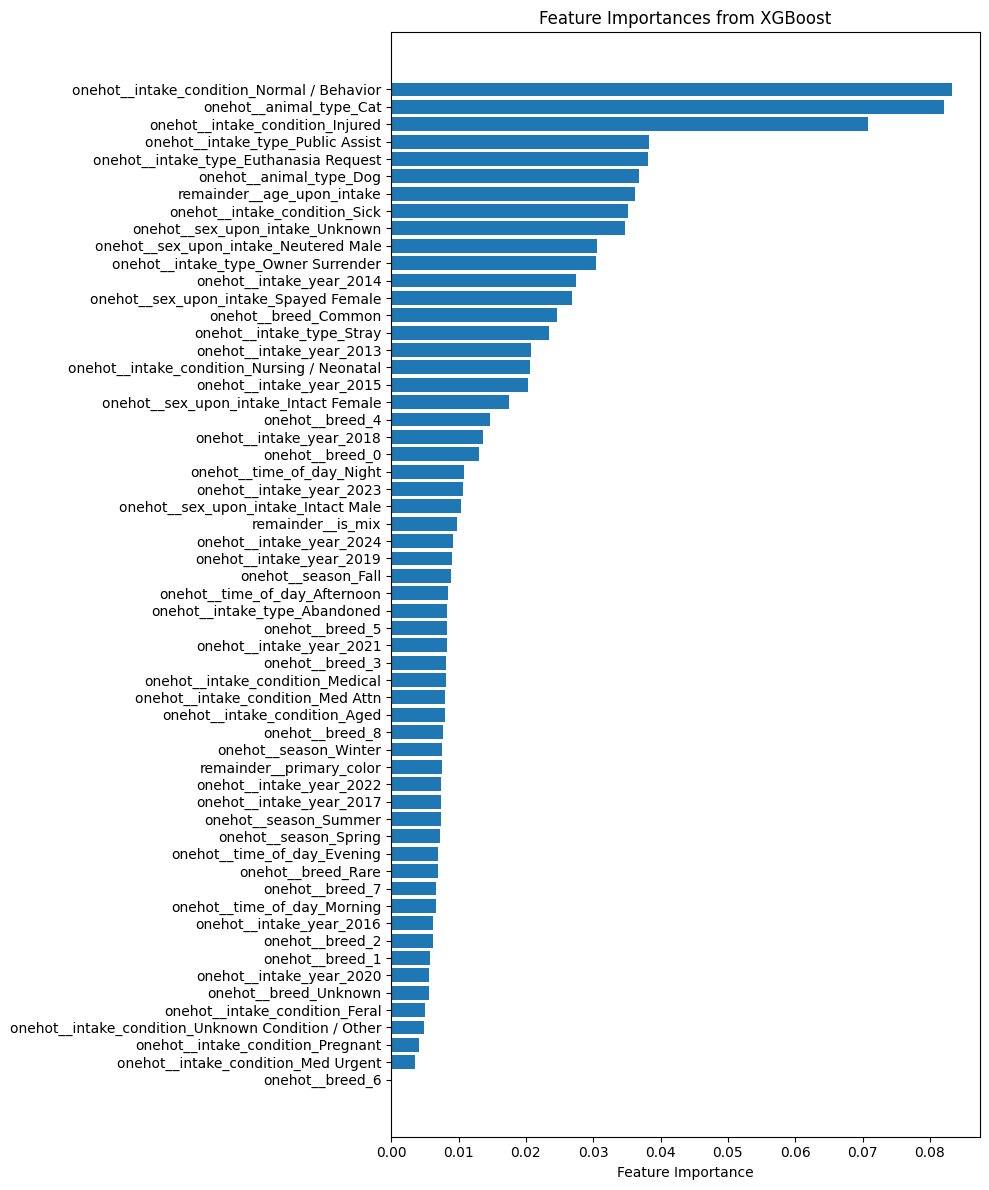

In [92]:
import matplotlib.pyplot as plt

df_plot = df_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from XGBoost')
plt.tight_layout()
plt.show()